# A data-driven way to merge similar classes together

Juan Lopez Martin

The quality of the classes is determinant for training a classifier. In the famous MNIST example, the handwritten number '6' was always labeled correclty as a '6'. However, it is clear it would be very problematic if that digit was sometimes labels as '6', others as 'six', 'SIX', '6s', etc. In this case, it would be necessary to merge all these labels together before training. If not, the classifier would probably pick up irrelevant features of the '6' to try to distinguish between the classes '6', 'six', '6s', etc and end up with much less prediction accuracy.

We are in a similar situation if we want to train a classifier to infer the issue from the narrative. For instance, some narratives have the issue 'Incorrect information on credit report', while others have 'Incorrect information on your report'. It is relatively clear that these two issues are not different, and that these two labels should be merged. The same happens, for instance, with 'Attempts to collect debt not owed' and 'Cont'd attempts collect debt not owed'.

## Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from operator import itemgetter
from itertools import compress
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import networkx 
from networkx.algorithms.components.connected import connected_components
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


In [5]:
folder = 'drive/My Drive/IBM/'
df = pd.read_csv(folder+'Consumer_Complaints.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df.dropna(subset=['Consumer complaint narrative'])

In [0]:
filename = folder+'texts.pickle'
infile = open(filename,'rb')
texts = pickle.load(infile)
infile.close()

In [0]:
filename = folder+'documents.pickle'
infile = open(filename,'rb')
documents = pickle.load(infile)
infile.close()

In [0]:
filename = folder+'model_100.pickle'
infile = open(filename,'rb')
model = pickle.load(infile)
infile.close()

In [0]:
# We use L2 normalization on the vectors
model.docvecs.init_sims(replace=True)

# Then take the appropiate sample
vecs_s = []
for i in range(0, df.shape[0]):
  if rand[i] == True:
    vecs_s.append(model.docvecs[i])
    
len(vecs_s)

## Data cleaning

We re using spacy to:

* Remove the X, XX, XXX, etc.
* Remove strings that are not alphanumeric
* Remove spaces
* Remove punctuation
* Remove numbers
* Lemmatize

This trasnforms the narrative to a list of words.

In [0]:
## Commented out -- output saved at model_100.pickle

#xs = ["X"*2, "X"*3, "X"*4, "X"*5, "X"*6, "X"*7, "X"*8, "X"*9, "X"*10, "X"*11, "XX/XX", "XX/XX/XXX", "XX/XX/XX", "XX/XXXX"]

#texts = []
#for sent in nlp.pipe(df['Consumer complaint narrative'], disable=["tagger", "parser", "ner", "textcat"]):
#    texts.append([word.lemma_ for word in sent 
#                  if word.is_alpha and
#                  not word.is_space and
#                  not word.is_stop and 
#                  not word.is_punct and 
#                  not word.like_num and 
#                     word.text not in xs])
    
#filename = folder+'texts.pickle'
#outfile = open(filename,'wb')
#pickle.dump(texts,outfile)
#outfile.close()

## Merging issues according to name

The first approach is to merge issues that have very similar names (e.g. 'Unable to get your credit report or credit score' and 'Unable to get credit report/credit score'). In this case, we will tokenize the issues into words and merge them if the words present at both account for more than 70% of the words in either. In other words, if we have issues $A$ and $B$ with length:

$len(A) = len([Unable, to, get, your, credit, report, or, credit, score]) = 9$ $len(B) = len([Unable, to, get, credit, report/credit, score]) = 6$

We will merge them if the intersection $A \cap B$ with length $ len(A \cap B)= len([Unable, to, get, credit, score]) = 5$ is more than $0.7 * len(A)$ or $0.7 * len(B)$. In this example, $len(A \cap B) > 0.7 * len(B)$ so we will merge the two labels. For convenience, we will keep the shortest name.

Lastly, note that merges of issues can be multiple. Namely, if issue $A$ is going to be merged with $B$, and $B$ is also going to be merged with $C$, we are going to obtain one new issue $K = A \cup B \cup C$. This is similar to say that, given a network $G = (V, E)$ in which each vertex is an original issue and the edges are $1$ if the issues are going to be merged and $0$ otherwise, we are going to keep all the distinct components as labels.

In [0]:
len(df['Issue'].value_counts())

In [0]:
def intersection(lst1, lst2): 
	lst3 = [value for value in lst1 if value in lst2] 
	return lst3

issues = [issue.split(" ") for issue in list(df['Issue'].value_counts().index)]

tomerge = []

for issue1 in issues:
  issues.remove(issue1)
  for issue2 in issues:
    inter = intersection(issue1, issue2)
    if len(inter)>0.70*len(issue2) or len(inter)>0.70*len(issue1):
      toappend = [" ".join(issue1), " ".join(issue2)]
      tomerge.append(toappend)

In [0]:
# Finding components in the network.
# Code from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements?lq=1

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(tomerge)
components = list(connected_components(G))

key = []
value = []

for aset in components:
  if len(aset)>1:
    value.append(min(filter(None, aset), key=len))
    key.append(list(aset))

In [0]:
key

In [0]:
df['Issue1'] = df['Issue']
for v, k in zip(value, key):
  df['Issue1'] = df['Issue1'].replace(dict.fromkeys(k, v))

In [0]:
len(df['Issue1'].value_counts())

This simple approach has reduced the number of issues from 161 to 129.

## Merging issues according to semantic content using Doc2vec

We have now mered issues with very similar names. However, could still issues that overlap significantly but that have been assigned very different names. To merge this, we will use word embeddings to capture the semantic content of the issues and decide which ones to merge together.


Word embeddings are vector representations of individual words that carry their semantic meaning. If these word vectors are obtained from a large corpus we would expect, for instance, that the vector for frog and toad will be very similar. Additionally, these vectors capture more complex relationships. For instance, the association between 'Washington' and USA will be similar as the association between 'China' and 'Beijin'. Doc2vec is an extension to the famous word embedding approach that trains vector representations of entire documents instead of just words. If trained on a large set of books we would expect, for instance, that Statistics books will have similar vectors.

In this case, we will train document embeddings based on the narratives. In other words, each narrative will be transformed into a 300-dimensional vector. The main advantge of this approach over simpler methods is that it takes into account the order of the words in sentences. In fact, under the hood the vectors are built by trying to predict a center word based on the surrounding words (PV-DM). This allows to capture complex semantic relationships between words.

The hyperparamethers used here are relatively standard in the field:

* 300-dimensional vectors.
* Window of 15 words (meaning we try to predict the center word from a 15-word window).
* Negative sampling of 5 -- improves results and reduces computational cost.
* 100 epochs. This is good but it took 4 hours.


In [0]:
## Commented out -- output saved at model_100.pickle

# First, we create a taggeddocument object, necessary for word2vec. Then we
# train the vecs.

#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
#model = Doc2Vec(documents, dm = 1, vector_size=300, window=15, negative=5, min_count=1, workers=4, epochs = 100)

#filename = folder+'model_100.pickle'
#outfile = open(filename,'wb')
#model = pickle.dump(model, outfile)
#outfile.close()

## Selecting labels to merge

For each issue (class) we have a set of narratives (documents) that have been represented as (300-dimensional L2-normalized) vectors with the doc2vec algorithm. For example, for issue $A$ ('Incorrect information on your report') we have obtained $a_1, a_2, ..., a_{65508}$ vectors. One basic approach to summarize the information we have about the issue $A$ is to calculate the mean for all the vectors $a_i$. Doing this, we obtain an average (300-dimensional L2-normalized) vector that can be seen as an approximate representation of the issue $A$. The idea is that the average of the vectors $a_i$ should contain that is to a certain degree common for the issue $A$.   

In [0]:
# Create list of issues ordered by value_counts
issues_list = list(df['Issue1'].value_counts().index)

# Calculate the mean for the vectors corresponding to each issue
vec_list = [np.mean(np.array(list(compress(vecs_s, list(df['Issue1']==issue)))), axis  = 0) for issue in issues_list]

Now we have a vector representation of issue $A$, $B$, $C$, etc. In word2vec the similarity of two vectors is measured using cosine similarity, which determines whether the two vectors are pointing in approximately the same direction.


We will create a similarity matrix that reports the cosine similarity between all the issues. If you have no experience with word2vec, this can be conceptually similar to a correlation matrix. That is, issues that are similar between each other will have a cosine similarity close to one and non-related issues a score close to zero.

In [0]:
# Create distance matrix with cosine similarity
dist = 1-pairwise_distances(np.array(vec_list), metric="cosine")

# Put the distance matrix in a dataframe with index and column names
dist_df = pd.DataFrame(dist, index = issues_list, columns=issues_list)

dist_df.iloc[0:5,0:5]

,Incorrect information on your report,Problem with a credit reporting company's investigation into an existing problem,Attempts to collect debt not owed,Improper use of your report,Cont'd attempts collect debt not owed
Incorrect information on your report,1.000000,0.990238,0.958919,0.963062,0.957848
Problem with a credit reporting company's investigation into an existing problem,0.990238,1.000000,0.947416,0.950580,0.945692
Attempts to collect debt not owed,0.958919,0.947416,1.000000,0.928875,0.996573
Improper use of your report,0.963062,0.950580,0.928875,1.000000,0.927949
Cont'd attempts collect debt not owed,0.957848,0.945692,0.996573,0.927949,1.000000


With this information we can use hierarchical clustering and draw a dendogram. 

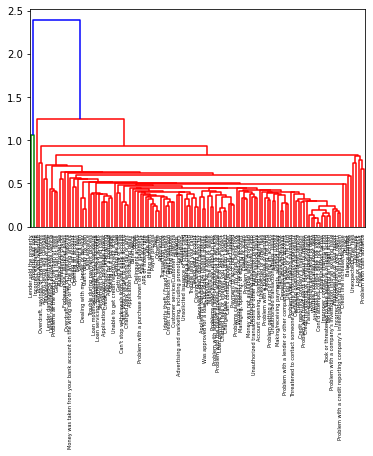

In [0]:
from scipy.cluster.hierarchy import linkage, dendrogram

dendro = dendrogram(linkage(dist_df, method = 'single'), labels = dist_df.index)

Now, we must decide some cutoff point to merge labels. In this case, we choose 0.18 because it merged issues that were apparently very similar while maintining the separation of distinct issues. With this approach, we get 118 issues. 

In [0]:
assignments = fcluster(linkage(dist_df, method = 'single'),0.18,'distance')

print("Merging the following issues:")

key = []
value = []
for cluster in set(assignments):
  tomerge = list(dist_df[cluster==assignments].index)
  if len(tomerge)>1:
    print(tomerge)
    key.append(tomerge[1:])
    value.append(tomerge[0])

df['Issue2'] = df['Issue1']
for v, k in zip(value, key):
  df['Issue2'] = df['Issue2'].replace(dict.fromkeys(k, v))

print("\n Number of resulting issues:")

len(df['Issue2'].value_counts())

Merging the following issues:
['Problem with the payoff process at the end of the loan', "Loan payment wasn't credited to your account"]
["Charged fees or interest you didn't expect", "Charged fees or interest I didn't expect"]
['Managing an account', 'Deposits and withdrawals']
['Attempts to collect debt not owed', "Cont'd attempts collect debt not owed", 'Written notification about debt', 'False statements or representation', 'Disclosure verification of debt']
['Communication tactics', 'Took or threatened to take negative or legal action', 'Taking/threatening an illegal action', 'Improper contact or sharing of info']
['Incorrect information on your report', "Problem with a credit reporting company's investigation into an existing problem"]

 Number of resulting issues:


118

As an example, a cutoff of 0.3 merges too many issues together, resulting in cluster that are more difficult to interpret.  

In [0]:
assignments = fcluster(linkage(dist_df, method = 'single'),0.30,'distance')

print("Merging the following issues:")

key = []
value = []
for cluster in set(assignments):
  tomerge = list(dist_df[cluster==assignments].index)
  if len(tomerge)>1:
    print(tomerge)
    key.append(tomerge[1:])
    value.append(tomerge[0])

df['Issue3'] = df['Issue1']
for v, k in zip(value, key):
  df['Issue3'] = df['Issue3'].replace(dict.fromkeys(k, v))

print("\n Number of resulting issues:")

len(df['Issue3'].value_counts())

Merging the following issues:
['Dealing with my lender or servicer', "Can't repay my loan"]
['Application, originator, mortgage broker', 'Settlement process and costs', 'Credit decision / Underwriting']
["Can't stop charges to bank account", "Can't stop withdrawals from your bank account", 'Charged bank acct wrong day or amt']
['Fees', 'Billing statement', 'Payoff process', 'Other fee']
['Billing disputes', 'Identity theft / Fraud / Embezzlement', 'Customer service/Customer relations', 'Credit card protection / Debt protection']
['Getting a credit card', 'Credit determination']
['Closing your account', 'Closing/Cancelling account']
['Applied for loan/did not receive money', "Was approved for a loan, but didn't receive money"]
['Managing the loan or lease', 'Problems when you are unable to pay']
["Charged fees or interest you didn't expect", "Charged fees or interest I didn't expect", 'Problem with the payoff process at the end of the loan', "Loan payment wasn't credited to your account

91

### Removing low-frequency issues

The last step is removing very low-frequency issues. In this case, any issue with less than 50 cases in the whole dataset is added to the issue 'Other'. With this, we end up with 103 issues.

In [0]:
issue2counts = df['Issue2'].value_counts()

toremove = issue2counts[issue2counts<50]

print("Issues to remove:\n")
print(toremove)

for trm in toremove.index:
  df['Issue2'] = df['Issue2'].replace(trm, "Other")

Issues to remove:

Convenience checks                         37
Overlimit fee                              31
Lender repossessed or sold the vehicle     31
Credit limit changed                       25
Incorrect exchange rate                    23
Unexpected/Other fees                      22
Problem with cash advance                  22
Overdraft, savings or rewards features     17
Account terms and changes                  17
Managing the line of credit                16
Problem with overdraft                     15
Disclosures                                13
Overdraft, savings, or rewards features    11
Lender sold the property                    3
Property was sold                           3
Name: Issue2, dtype: int64


In [0]:
len(df['Issue2'].value_counts())

103

In [0]:
issue2counts = df['Issue3'].value_counts()

toremove = issue2counts[issue2counts<50]

print("Issues to remove:\n")
print(toremove)

for trm in toremove.index:
  df['Issue3'] = df['Issue3'].replace(trm, "Other")

len(df['Issue3'].value_counts())

Issues to remove:

Convenience checks                         37
Lender repossessed or sold the vehicle     31
Overlimit fee                              31
Credit limit changed                       25
Incorrect exchange rate                    23
Problem with cash advance                  22
Unexpected/Other fees                      22
Overdraft, savings or rewards features     17
Account terms and changes                  17
Managing the line of credit                16
Problem with overdraft                     15
Disclosures                                13
Overdraft, savings, or rewards features    11
Lender sold the property                    3
Property was sold                           3
Name: Issue3, dtype: int64


76

In [0]:
df.to_csv(folder+'Consumer_Complaints2.csv')

In [0]:
mylist = []

def myfunc(narr, components):
  for comp in components:
    if narr in comp:
       return '_'.join(comp)

for i,narr in enumerate(df['Issue']):
  mylist.append(myfunc(narr, components))


In [0]:
df['Cluster1'] = mylist

In [0]:
dist_df.loc[df['Cluster1'].value_counts()[-20:].index,df['Cluster1'].value_counts()[-20:].index]

,Vehicle was damaged or destroyed the vehicle,"Advertising, marketing or disclosures",Credit limit changed,Incorrect exchange rate,Unexpected/Other fees,Problem with cash advance,"Overdraft, savings or rewards features",Account terms and changes,Managing the line of credit,Disclosures,Problem with overdraft,"Was approved for a loan, but didn't receive money","Overdraft, savings, or rewards features",Shopping for a line of credit,Lender sold the property,Property was sold,Lender damaged or destroyed vehicle,Property was damaged or destroyed property,Problem with an overdraft,Lender damaged or destroyed property
Vehicle was damaged or destroyed the vehicle,1.000000,0.459187,0.572435,0.371144,0.472290,0.528627,0.512479,0.626855,0.619699,0.480402,0.428950,0.515739,0.464561,0.514761,0.284773,0.324818,0.325403,0.345185,0.205639,0.267597
"Advertising, marketing or disclosures",0.459187,1.000000,0.504206,0.429985,0.524860,0.572374,0.705233,0.529096,0.534186,0.514625,0.584607,0.491694,0.535404,0.474074,0.253123,0.342645,0.295579,0.267239,0.286864,0.176071
Credit limit changed,0.572435,0.504206,1.000000,0.413698,0.500369,0.674496,0.536792,0.638808,0.616679,0.514874,0.463671,0.534928,0.475172,0.545032,0.331367,0.282124,0.272670,0.346081,0.146642,0.206867
Incorrect exchange rate,0.371144,0.429985,0.413698,1.000000,0.441019,0.435708,0.444405,0.441570,0.418664,0.384561,0.431219,0.328092,0.457129,0.334454,0.225561,0.271162,0.229297,0.200652,0.153090,0.180563
Unexpected/Other fees,0.472290,0.524860,0.500369,0.441019,1.000000,0.503455,0.607299,0.516276,0.549111,0.615856,0.543329,0.419395,0.533436,0.440350,0.253698,0.315546,0.256506,0.250478,0.318883,0.239658
Problem with cash advance,0.528627,0.572374,0.674496,0.435708,0.503455,1.000000,0.549588,0.604610,0.555971,0.519661,0.517558,0.542699,0.489934,0.519085,0.345633,0.280471,0.359741,0.320047,0.325853,0.197672
"Overdraft, savings or rewards features",0.512479,0.705233,0.536792,0.444405,0.607299,0.549588,1.000000,0.583646,0.589843,0.533556,0.674716,0.435925,0.596713,0.478897,0.265637,0.327537,0.257968,0.296517,0.335693,0.242940
Account terms and changes,0.626855,0.529096,0.638808,0.441570,0.516276,0.604610,0.583646,1.000000,0.662682,0.558640,0.497405,0.453833,0.537059,0.559787,0.347591,0.340150,0.274191,0.275469,0.255456,0.239588
Managing the line of credit,0.619699,0.534186,0.616679,0.418664,0.549111,0.555971,0.589843,0.662682,1.000000,0.562385,0.471284,0.536695,0.489240,0.542475,0.307404,0.267110,0.375734,0.340805,0.210052,0.252436
Disclosures,0.480402,0.514625,0.514874,0.384561,0.615856,0.519661,0.533556,0.558640,0.562385,1.000000,0.438632,0.456369,0.461448,0.501987,0.188697,0.265692,0.273694,0.289511,0.289643,0.270306


In [0]:
# The issues to merge are decided according to an user-defined threshold.
threshold = 0.985
l = [list(dist_df[dist_df.loc[issue]>threshold].index) for issue in issues_list]

# Finding components in the network.
# Code from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements?lq=1

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
components = list(connected_components(G))

for aset in components:
  if len(aset)>1:
    for element in aset:
      print(element)
    print("\n")

Credit reporting company's investigation
Incorrect information on your report
Problem with a credit reporting company's investigation into an existing problem


Cont'd attempts collect debt not owed
Attempts to collect debt not owed


Trouble during payment process
Loan servicing, payments, escrow account


Written notification about debt
Disclosure verification of debt


Managing an account
Deposits and withdrawals


Took or threatened to take negative or legal action
Taking/threatening an illegal action


Applying for a mortgage
Application, originator, mortgage broker




In [0]:
vec_list = [np.array(list(compress(vecs_s, list(df[rand]['Issue']==issue)))) for issue in issues_list]

In [0]:
A = vec_list[0]

In [0]:
def cos_sim_sets(setA, setB):
  if setA.shape[0]>1000:
    setA = setA[np.random.choice(setA.shape[0], 1000, replace=False), :]
  if setB.shape[0]>1000:
    setB = setB[np.random.choice(setB.shape[0], 1000, replace=False), :]

  return cosine_similarity(setA, setB)
  

In [0]:
sim_mat = np.zeros((len(issues_list),len(issues_list)))

for i in range(0, len(issues_list)):
  for j in range(0, len(issues_list)):
    sim_mat[i,j] = np.mean(cos_sim_sets(vec_list[i], vec_list[j]))

In [0]:
sim_df = pd.DataFrame(sim_mat, index = issues_list, columns=issues_list)

In [0]:
# The issues to merge are decided according to an user-defined threshold.
#tres = 0.0
#l = [list(sim_df[sim_df.loc[issue]>sim_df.loc[issue,issue]-tres].index) for issue in issues_list]
threshold = 0.16
l = [list(sim_df[sim_df.loc[issue]>threshold].index) for issue in issues_list]


# Finding components in the network.
# Code from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements?lq=1

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        # each sublist is a bunch of nodes
        G.add_nodes_from(part)
        # it also imlies a number of edges:
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

G = to_graph(l)
components = list(connected_components(G))

for aset in components:
  if len(aset)>1:
    for element in aset:
      print(element)
    print("\n")

Problem with a credit reporting company's investigation into an existing problem
Attempts to collect debt not owed
Credit reporting company's investigation
Cont'd attempts collect debt not owed
Incorrect information on credit report
Problem adding money
Disclosure verification of debt
Problem when making payments
Bankruptcy
Written notification about debt
Unable to get credit report/credit score
Improper contact or sharing of info
Problem with fraud alerts or security freezes
Improper use of my credit report
Improper use of your report
Incorrect information on your report


Property was damaged or destroyed property
Lender damaged or destroyed property


